In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pickle

In [41]:
hist_cash = pd.read_csv('assets/models/joey_cnn_intraday/75percent_confidence_no_holding_15m/hist_cash.csv').drop(columns=['Unnamed: 0'])
hist_trades = pd.read_csv('assets/models/joey_cnn_intraday/75percent_confidence_no_holding_15m/hist_trades.csv').drop(columns=['Unnamed: 0'])

In [42]:
hist_cash.head()

,Date,Cash Available to Trade
0,2020-07-20,100000.000000
1,2020-07-20 06:00:00,100000.000000
2,2020-07-20 06:00:00,20546.911410
3,2020-07-20 06:15:00,100013.629294
4,2020-07-20 06:15:00,20050.679294


In [43]:
hist_trades.head()

,Date,Order Type,Ticker,Quantity,Ticker Value,Total Trade Value,Remaining Cash
0,2020-07-20 06:00:00,buy,SPY,63,316.213585,19921.455843,80078.544157
1,2020-07-20 06:00:00,buy,QQQ,77,257.937166,19861.161749,60217.382409
2,2020-07-20 06:00:00,buy,MSFT,98,202.390903,19834.308498,40383.073910
3,2020-07-20 06:00:00,buy,BABA,77,257.612500,19836.162500,20546.911410
4,2020-07-20 06:15:00,sell,SPY,63,316.164324,19918.352425,40465.263836


In [44]:
hist_trades['Date'] = pd.to_datetime(hist_trades['Date'])
trades = hist_trades[hist_trades['Order Type'] == 'buy'].groupby(by=[hist_trades['Date'].dt.date, 'Ticker']).sum().reset_index()

In [45]:
trades.sort_values(['Date', 'Total Trade Value'], ascending=True).groupby('Date').head(1)

,Date,Ticker,Quantity,Ticker Value,Total Trade Value,Remaining Cash
4,2020-07-20,JNJ,1229,2477.942746,179156.380999,9.049261e+05
16,2020-07-21,JNJ,1000,1613.171401,146725.465711,6.467946e+05
28,2020-07-22,JNJ,1613,2620.520088,234742.175573,1.050238e+06
40,2020-07-23,JNJ,1337,1462.132294,195460.020932,5.651115e+05
52,2020-07-24,JNJ,901,1443.461245,130106.119069,5.244609e+05
...,...,...,...,...,...,...
3016,2021-07-19,JNJ,829,2163.622350,138029.351575,7.810826e+05
3028,2021-07-20,JNJ,1232,1859.743775,208213.523075,6.543547e+05
3038,2021-07-21,BAC,5267,615.497400,202550.667225,4.600480e+05
3052,2021-07-22,JNJ,1175,2042.309925,200039.140625,7.075774e+05


In [46]:
trades.sort_values(['Date', 'Quantity'], ascending=True).groupby('Date').head(1)['Ticker']

11      TSLA
16       JNJ
35      TSLA
37      BABA
52       JNJ
        ... 
3023    TSLA
3035    TSLA
3047    TSLA
3059    TSLA
3071    TSLA
Name: Ticker, Length: 256, dtype: object

In [47]:
trades.sort_values(['Date', 'Quantity'], ascending=True).groupby('Date').head(1)['Ticker'].value_counts()

TSLA    178
JNJ      27
BABA     19
SPY      17
MSFT      8
JPM       6
QQQ       1
Name: Ticker, dtype: int64

In [48]:
hist_trades['Net Change'] = np.where(hist_trades['Order Type'] == 'buy', -hist_trades['Total Trade Value'], hist_trades['Total Trade Value'])
hist_trades

,Date,Order Type,Ticker,Quantity,Ticker Value,Total Trade Value,Remaining Cash,Net Change
0,2020-07-20 06:00:00,buy,SPY,63,316.213585,19921.455843,80078.544157,-19921.455843
1,2020-07-20 06:00:00,buy,QQQ,77,257.937166,19861.161749,60217.382409,-19861.161749
2,2020-07-20 06:00:00,buy,MSFT,98,202.390903,19834.308498,40383.073910,-19834.308498
3,2020-07-20 06:00:00,buy,BABA,77,257.612500,19836.162500,20546.911410,-19836.162500
4,2020-07-20 06:15:00,sell,SPY,63,316.164324,19918.352425,40465.263836,19918.352425
...,...,...,...,...,...,...,...,...
142789,2021-07-23 19:45:00,sell,AMD,480,92.095000,44205.600000,110594.203465,44205.600000
142790,2021-07-23 19:45:00,buy,QQQ,120,367.840000,44140.800000,66453.403465,-44140.800000
142791,2021-07-23 19:45:00,buy,AMD,480,92.095000,44205.600000,22247.803465,-44205.600000
142792,2021-07-23 20:00:00,sell,QQQ,120,367.867500,44144.100000,66391.903465,44144.100000


In [49]:
values = hist_trades.groupby(by=[hist_trades['Date'].dt.date, 'Ticker'])['Net Change'].sum().reset_index().set_index(['Date'])
values.loc['2020-07-19'] = ['', 0.0]
values.index = pd.to_datetime(values.index)
values = values.sort_values(['Date', 'Net Change'], ascending=[True, False]).groupby('Date').head(1)
values = values.rename(columns={'Ticker': 'Best Performing Ticker'})
values

,Best Performing Ticker,Net Change
Date,,
2020-07-19,,0.000000
2020-07-20,MRNA,707.677600
2020-07-21,TSLA,344.326290
2020-07-22,AMD,766.098650
2020-07-23,AMD,2193.777525
...,...,...
2021-07-19,NVDA,1570.433781
2021-07-20,BAC,174.621100
2021-07-21,AMD,130.500725


In [50]:
hist_cash = pd.read_csv('assets/models/joey_cnn_intraday/50percent_confidence_holding_15m/hist_cash.csv').drop(columns=['Unnamed: 0'])
hist_cash = hist_cash.set_index(['Date'])
hist_cash.index = pd.to_datetime(hist_cash.index)
hist_cash = hist_cash.sort_index()
hist_cash = hist_cash.groupby(pd.Grouper(freq='D')).last()
hist_cash['Rate of Return'] = hist_cash['Cash Available to Trade'].apply(lambda x: (x - 100000) / x)
hist_cash = hist_cash.join(values)
hist_cash['diff'] = hist_cash['Cash Available to Trade'].diff()
hist_cash['Contribution'] = abs(hist_cash['Net Change'] / hist_cash['diff'] * 100)
hist_cash['Best Performing Ticker'] = hist_cash['Best Performing Ticker'].fillna('')
hist_cash['Contribution'] = hist_cash['Contribution'].fillna(0.0)
hist_cash['text'] = hist_cash.apply(lambda x: f"Daily Gross = {x['diff']:.2f}{'<br>'}Best Performing Ticker = {x['Best Performing Ticker']}{'<br>'}Contribution = {x['Contribution']:.2f}%", axis=1)
hist_cash

,Cash Available to Trade,Rate of Return,Best Performing Ticker,Net Change,diff,Contribution,text
Date,,,,,,,
2020-07-19,100000.0000,0.000000,,0.000000,NaN,0.000000,Daily Gross = nan<br>Best Performing Ticker = ...
2020-07-20,102126.2298,0.020820,MRNA,707.677600,2126.2298,33.283213,Daily Gross = 2126.23<br>Best Performing Ticke...
2020-07-21,101447.4265,0.014268,TSLA,344.326290,-678.8033,50.725489,Daily Gross = -678.80<br>Best Performing Ticke...
2020-07-22,102702.7938,0.026317,AMD,766.098650,1255.3673,61.025857,Daily Gross = 1255.37<br>Best Performing Ticke...
2020-07-23,102327.8937,0.022749,AMD,2193.777525,-374.9001,585.163227,Daily Gross = -374.90<br>Best Performing Ticke...
...,...,...,...,...,...,...,...
2021-07-19,108300.3231,0.076642,NVDA,1570.433781,410.5003,382.565806,Daily Gross = 410.50<br>Best Performing Ticker...
2021-07-20,108191.2913,0.075711,BAC,174.621100,-109.0318,160.156120,Daily Gross = -109.03<br>Best Performing Ticke...
2021-07-21,108303.4499,0.076668,AMD,130.500725,112.1586,116.353739,Daily Gross = 112.16<br>Best Performing Ticker...


In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=hist_cash['Rate of Return'].apply(lambda x: float(str(x).strip('%'))), 
                 x=hist_cash.index, mode='lines', name='Returns',
                 text=hist_cash['text'].values))
fig.update_layout(width=950, height=300,
                  margin=dict(l=20, r=20, t=50, b=10),
                  paper_bgcolor='white', plot_bgcolor='white',
                  legend=dict(orientation="h"), yaxis_tickformat='.2%',
                  title=dict(text='Performance Chart', font=dict(size=20, color='black'), x=0.5, y=0.96))

fig.show()

In [52]:
test_df = hist_trades[hist_trades['Order Type'] == 'buy'].groupby(by=[hist_trades['Date'].dt.date, 'Ticker']).sum().reset_index().set_index('Date')
test_df = test_df[['Ticker', 'Quantity', 'Total Trade Value']]
test_df

,Ticker,Quantity,Total Trade Value
Date,,,
2020-07-20,AMD,5404,305958.257475
2020-07-20,BABA,1692,433770.791750
2020-07-20,BAC,19174,440440.421098
2020-07-20,F,54710,366230.399675
2020-07-20,JNJ,1229,179156.380999
...,...,...,...
2021-07-23,MSFT,1660,479446.871675
2021-07-23,NVDA,3503,685190.240400
2021-07-23,QQQ,1472,539411.405900


In [53]:
fig = go.Figure(data=[go.Pie(labels=test_df['Ticker'].iloc[10:15], values=test_df['Total Trade Value'].iloc[10:15], hole=0.4)])
fig.show()

In [54]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3,
                    specs=[[{'type': 'scatter'}, {}, {'type': 'pie'}]], 
                    horizontal_spacing=0.1, column_widths=[500, 750, 1])
fig.add_trace(go.Scatter(y=hist_cash['Rate of Return'].apply(lambda x: float(str(x).strip('%'))), 
                 x=hist_cash.index, mode='lines', name='Returns',
                 text=hist_cash['text'].values), row=1, col=1)
fig.update_layout(width=1000,margin=dict(l=20, r=20, t=50, b=10),
                  paper_bgcolor='white', plot_bgcolor='white',
                  legend=dict(orientation="h"), yaxis_tickformat='.2%',
                  title=dict(text='Performance Chart', font=dict(size=20, color='black'), x=0.5, y=0.96))
fig.add_trace(go.Pie(labels=test_df['Ticker'], values=test_df['Total Trade Value'], showlegend=False, hole=0.4))
fig.update_traces(textposition='inside', textinfo='percent+label', col=3)
fig.update_layout(width=2000, height=500)
fig.show()

<AxesSubplot:>

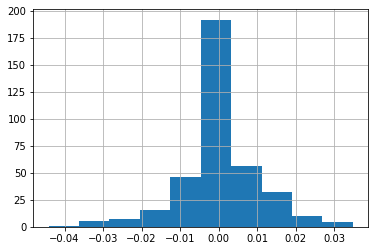

In [55]:
# histogram with earnings per day
new_df = hist_cash.copy()
new_df['Rate of Return'].diff().dropna().hist()

In [56]:
df = hist_trades.copy()
sell = df[df['Order Type'] == 'sell'].groupby(by=[df['Date'].dt.date, 'Ticker']).sum().reset_index().set_index('Date')
buy = df[df['Order Type'] == 'buy'].groupby(by=[df['Date'].dt.date, 'Ticker']).sum().reset_index().set_index('Date')
sell = sell[['Ticker', 'Ticker Value', 'Total Trade Value']]
buy = buy[['Ticker', 'Quantity', 'Ticker Value', 'Total Trade Value']]
sell = sell.rename(columns={'Ticker Value': 'Last', 'Total Trade Value': 'Current Value'}).reset_index()
buy = buy.rename(columns={'Ticker Value': 'Purchase Price', 'Total Trade Value': 'Basis'}).reset_index()
df = buy.merge(sell, on=['Date', 'Ticker']).set_index('Date')
def gain(basis, curr_value):
    return (basis - curr_value) / basis * 100
df['% Gain'] = df.apply(lambda x: gain(x['Basis'], x['Current Value']), axis=1)
df

,Ticker,Quantity,Purchase Price,Basis,Last,Current Value,% Gain
Date,,,,,,,
2020-07-20,AMD,5404,1188.950975,305958.257475,1190.483450,306254.862300,-0.096943
2020-07-20,BABA,1692,6388.849200,433770.791750,6385.678725,433576.962725,0.044685
2020-07-20,BAC,19174,620.394942,440440.421098,620.478926,440550.889512,-0.025081
2020-07-20,F,54710,160.750375,366230.399675,160.595100,366137.472500,0.025374
2020-07-20,JNJ,1229,2477.942746,179156.380999,2476.408723,179041.428959,0.064163
...,...,...,...,...,...,...,...
2021-07-23,MSFT,1660,7800.583525,479446.871675,7801.753800,479556.175825,-0.022798
2021-07-23,NVDA,3503,5661.758775,685190.240400,5658.773425,684601.710775,0.085893
2021-07-23,QQQ,1472,9167.625925,539411.405900,9168.497675,539449.534375,-0.007069


In [57]:
hist_cash.rename(columns={'Cash Available to Trade': 'Value'})

,Value,Rate of Return,Best Performing Ticker,Net Change,diff,Contribution,text
Date,,,,,,,
2020-07-19,100000.0000,0.000000,,0.000000,NaN,0.000000,Daily Gross = nan<br>Best Performing Ticker = ...
2020-07-20,102126.2298,0.020820,MRNA,707.677600,2126.2298,33.283213,Daily Gross = 2126.23<br>Best Performing Ticke...
2020-07-21,101447.4265,0.014268,TSLA,344.326290,-678.8033,50.725489,Daily Gross = -678.80<br>Best Performing Ticke...
2020-07-22,102702.7938,0.026317,AMD,766.098650,1255.3673,61.025857,Daily Gross = 1255.37<br>Best Performing Ticke...
2020-07-23,102327.8937,0.022749,AMD,2193.777525,-374.9001,585.163227,Daily Gross = -374.90<br>Best Performing Ticke...
...,...,...,...,...,...,...,...
2021-07-19,108300.3231,0.076642,NVDA,1570.433781,410.5003,382.565806,Daily Gross = 410.50<br>Best Performing Ticker...
2021-07-20,108191.2913,0.075711,BAC,174.621100,-109.0318,160.156120,Daily Gross = -109.03<br>Best Performing Ticke...
2021-07-21,108303.4499,0.076668,AMD,130.500725,112.1586,116.353739,Daily Gross = 112.16<br>Best Performing Ticker...


In [58]:
new_df = df.copy()
new_df

,Ticker,Quantity,Purchase Price,Basis,Last,Current Value,% Gain
Date,,,,,,,
2020-07-20,AMD,5404,1188.950975,305958.257475,1190.483450,306254.862300,-0.096943
2020-07-20,BABA,1692,6388.849200,433770.791750,6385.678725,433576.962725,0.044685
2020-07-20,BAC,19174,620.394942,440440.421098,620.478926,440550.889512,-0.025081
2020-07-20,F,54710,160.750375,366230.399675,160.595100,366137.472500,0.025374
2020-07-20,JNJ,1229,2477.942746,179156.380999,2476.408723,179041.428959,0.064163
...,...,...,...,...,...,...,...
2021-07-23,MSFT,1660,7800.583525,479446.871675,7801.753800,479556.175825,-0.022798
2021-07-23,NVDA,3503,5661.758775,685190.240400,5658.773425,684601.710775,0.085893
2021-07-23,QQQ,1472,9167.625925,539411.405900,9168.497675,539449.534375,-0.007069


In [77]:
pkl = pickle.load(open('assets/models/joey_cnn_intraday/history_100epochs.pkl', 'rb'))
pkl_df = pd.DataFrame([pkl['recall'], pkl['precision'], pkl['binary_crossentropy'], pkl['loss']]).T.rename(columns={0:'Recall', 1: 'Precision', 2:'Binary Crossentropy', 3: 'Loss'})
pkl_df = pkl_df.reset_index().rename(columns={'index': 'Epoch'})
pkl_df['Epoch'] = pkl_df['Epoch'] + 1
pkl_df.head()

,Epoch,Recall,Precision,Binary Crossentropy,Loss
0,1,0.676880,0.676880,2.807363,3.765005
1,2,0.749268,0.749268,1.007828,0.503693
2,3,0.777466,0.777466,1.111904,0.466356
3,4,0.792603,0.792603,1.293001,0.453376
4,5,0.791016,0.791016,1.053171,0.445899


<AxesSubplot:>

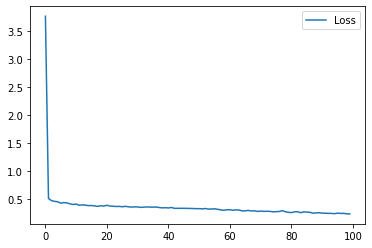

In [78]:
pkl_df[['Loss']].plot()

In [79]:
pkl_df.to_csv('assets/models/joey_cnn_intraday/cnn_training.csv')